# Jupyter notebook for testing the reeb graph algorithm on 3D objects
- Currently works for most 3D objects

In [1]:
import numpy as np
import trimesh
import pywavefront as py
import pipe
import networkx as nx
import matplotlib.pyplot as plt

from src.Undirected import Undirectedgraph,Utils
from src.graph import Graph
from src.vertex import Vertex
from collections import defaultdict
from tabnanny import verbose
from pipe import where,select,traverse,dedup
from copy import deepcopy

In [ ]:
class Disjoint_set():


    def __init__(self,n : int):
        self.n = n 
        self.parent = [i for i in range(self.n)]
        self.rank = [0 for x in range(self.n)]

    def find(self,x : int):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self,x : int,y : int):
        x_root = self.find(x)
        y_root = self.find(y)
        print('parent array before union :',self.parent)
        print(x_root,y_root)
        if x_root == y_root:
            return
        if self.rank[x_root] > self.rank[y_root]:
            self.parent[y_root] = x_root
            print('parent array after union :',self.parent)
            print('\nrank array :',self.rank)
        else:    
            self.parent[x_root] = y_root
            print('parent array after union =>',self.parent)
            print('\nrank array :',self.rank)
            if self.rank[x_root] == self.rank[y_root]:
                self.rank[y_root]+=1
    
    def print_parents(self):
        print('index :',list(range(1,self.n)))
        print('parent: ',self.parent[1:],sep='')
        print('rank : ',self.rank[1:],sep=' ')  


if __name__ == '__main__':
    # Part a)
    uf = Disjoint_set(10)
    uf.print_parents()
    uf.union(1,2)
    uf.union(3,4)
    uf.union(5,6)
    # uf.union(2,4)
    # uf.union(4,5)
    print("\nParent array after union(2,1), union(4,3) and union(6,5):")
    uf.print_parents()  




In [3]:
# define the object of your choice ti be used by the subsequent class Objtograph
vertices=np.array([
 [-0.5, -0.5, 0.5],
 [-0.5, -0.5, -0.5],
 [-0.5, 0.5, -0.5],
 [-0.5, 0.5, 0.5],
 [0.5, -0.5, 0.5],
 [0.5, -0.5, -0.5],
 [0.5, 0.5, -0.5],
 [0.5, 0.5, 0.5]])

faces= np.array([
[0, 3, 7, 4],
[1, 2, 6, 5],
[0, 3, 2, 1],
[4, 5, 6, 7],
[0, 1, 5, 4],
[2, 3, 7, 0]])

cube=trimesh.Trimesh(vertices=vertices,faces=faces)
object=trimesh.load_mesh('./data/box.obj')

specified material (Default)  not loaded!


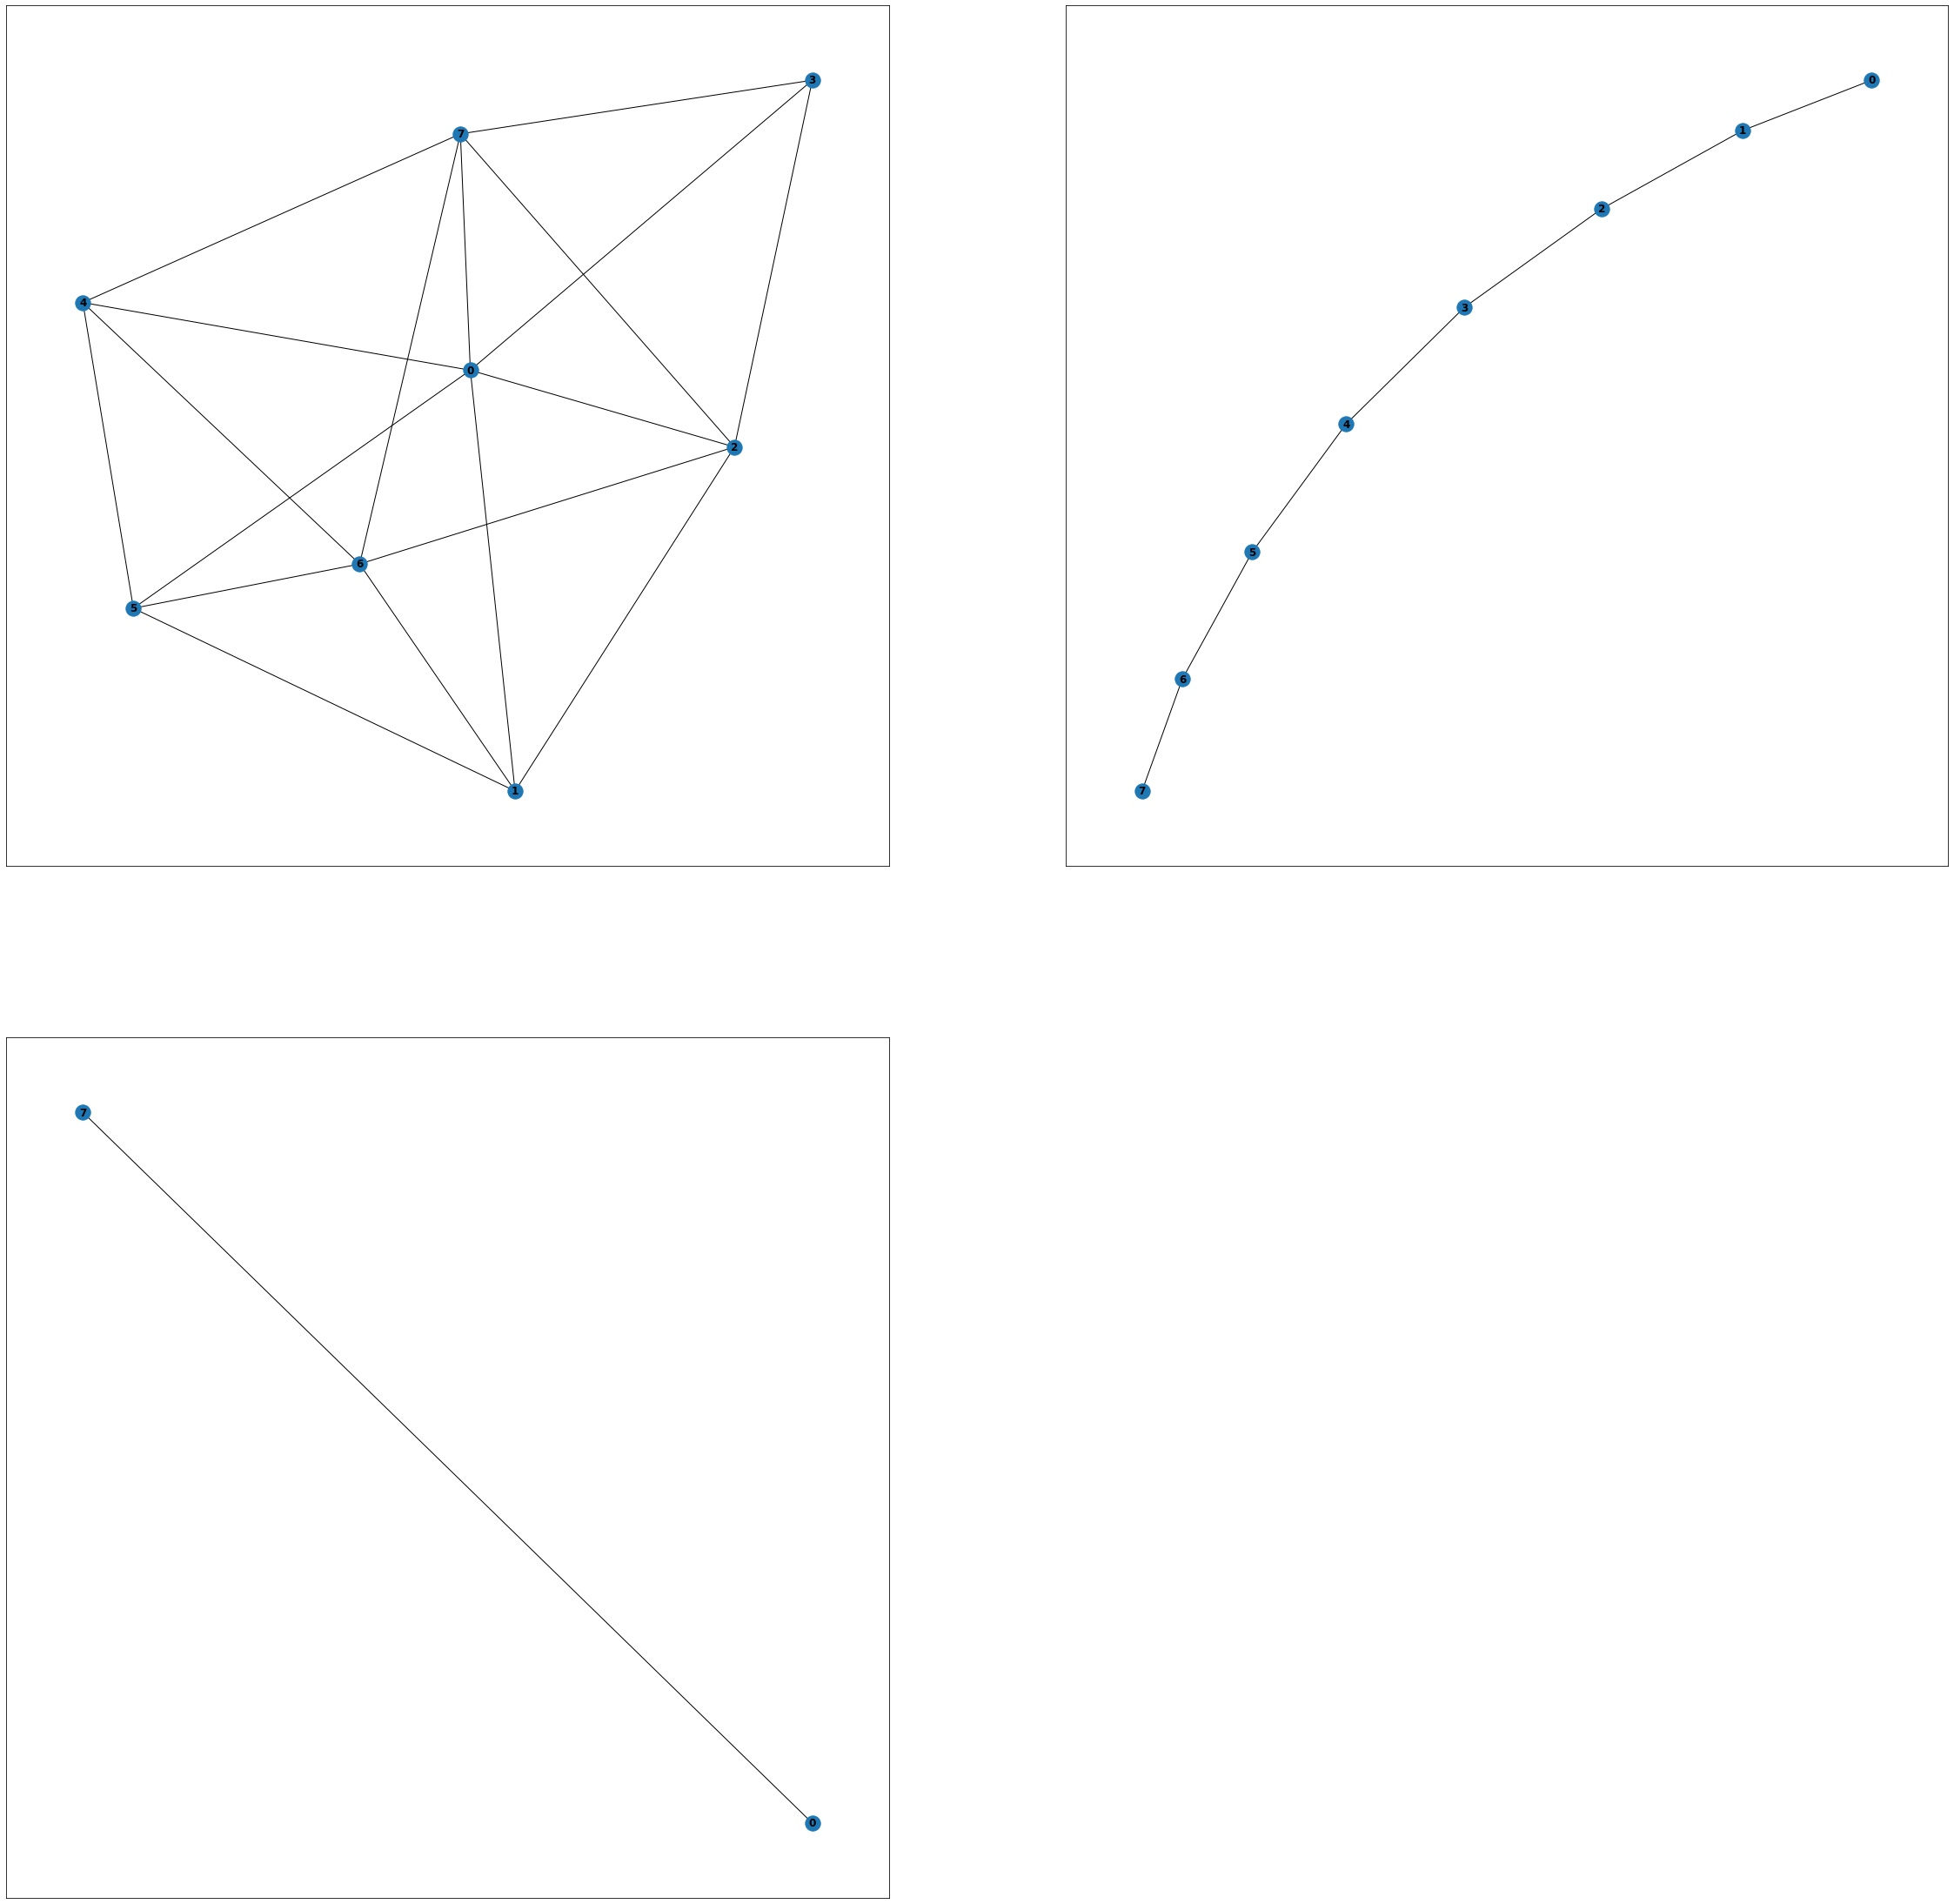

In [5]:
class Objtograph:
    
    def __init__(self,obj,tree_type='merge'):
        
        # super(self,obj,Obj2graph).__init__()
        self.obj = obj
        self.objgraph = defaultdict(list)
        self.graph = defaultdict(list)
        self.tree_type = tree_type

    def __call__(self):
        print(self.objgraph)
    
    # degree of a node 
    def degree(self,node) -> int:
        return len(self.graph[node])

    # get adjacent neighbours of a node in tree 
    def get_neighbours(self,node):
        return self.graph[node]

    def is_neighbour(self,subset,node):
        for element in subset:
            if node in self.objgraph[element]:
                return True
        return False

    # method to delete a node and its connected edges
    def delete(self,n):
        list(self.graph[n] | select(lambda x:self.graph[x].remove(n)))
        del(self.graph[n])

    # function to add an edge to graph
    def addEdge(self,u,v):
        self.graph[u].append(v)
        self.graph[v].append(u)

    def build_adj(self):
        Utils.print(f'object has {object.faces} faces')
        for f in self.obj.faces:

            if f[0] not in self.objgraph.keys():
                self.objgraph[f[0]] = [f[1],f[2]]  
            else:
                self.objgraph[f[0]].extend([f[1],f[2]])

            if f[1] not in self.objgraph.keys():
                self.objgraph[f[1]] = [f[0],f[2]]  
            else:
                self.objgraph[f[1]].extend([f[0],f[2]])
            
            if f[2] not in self.objgraph.keys():
                self.objgraph[f[2]] = [f[0],f[1]]  
            else:
                self.objgraph[f[2]].extend([f[0],f[1]])

        for key in self.objgraph:
            self.objgraph[key] = list(set(self.objgraph[key]))
        
    # utility to merge connected components
    def merge_sets(self,sets,node):
        con_com = {node:[],-1:[]}
        Utils.print(f'before merging processed_nodes: {sets}')
        for subset in sets:
            if node in subset:
                con_com[node].append(subset)
                con_com[node] = list(con_com[node] | traverse | dedup)
            else:
                con_com[-1].append(subset)

        sets = [con_com[node]]
        if len(con_com[-1])!= 0:
            for i in con_com[-1]: sets.append(i)
        con_com.clear()
        Utils.print(f'post merging processed_nodes: {sets}')
        return sets   

    def build_tree(self,node,processed_nodes):
        flag_no_neigbhour = True
        if len(processed_nodes)!=0:
            for idx,subset in enumerate(processed_nodes):
                
                
                Utils.print(f'\nsubset {subset} from processed nodes {processed_nodes}, node is {node}')
                Utils.print(f'is node {node} a neighbour of subset {subset}: {self.is_neighbour(subset,node)}')
                
                if self.is_neighbour(subset,node):
                    if self.tree_type == 'merge':
                        self.addEdge(np.max(subset),node)
                    else:
                        self.addEdge(np.min(subset),node)
                Utils.print(f'merging node {node} to subset {subset} in processed_nodes')
                
                processed_nodes[idx].append(node)
                flag_no_neigbhour = False

            if flag_no_neigbhour:
                processed_nodes.append([node])
            else:
                processed_nodes = self.merge_sets(processed_nodes,node)
        else:
            processed_nodes.append([node])
        return processed_nodes
    
    # optimized iterative algorithm 
    def augment2(self,root: int):
        '''
        Args
            root:any node in graph 

        Purpose
            Iterative method of Graph augmentation of graph retaining only critical nodes(a.k.a saddle points)
            and root nodes reducing the size of graph considerably

        Output
            returns: None

        time complexity: O(n^2)
        Space complexity: O(n)
        '''
        to_visit=[]
        to_visit.append(root)
        counter=0
        
        while(counter<len(to_visit)):
            node=to_visit[counter]
            neighbours=self.get_neighbours(node)
            Utils.print(f'node is {node} neighbours are: {neighbours}')
            if self.degree(node)==2:
                self.addEdge(neighbours[0],neighbours[1])
                self.delete(node)
            to_visit=to_visit+list(neighbours | where(lambda x: x not in to_visit))
            counter+=1

        del(to_visit)
        del(counter)

if __name__ == "__main__":
    Utils.verbose = False
    tree_type = str(input("enter type of tree 'merge/split' :"))
    # object=trimesh.load_mesh('./data/mug.ply')
    g = Objtograph(obj=cube)
    g.build_adj()
    G_object = g.objgraph
    Utils.print(g.objgraph)
    Utils.print(list(g.objgraph.keys()))

    processed_nodes = []
    nodes = list(g.objgraph.keys())
    Utils.print(f'nodes are {nodes}')
    for node in sorted(nodes):
        Utils.print(f'node is {node}, processed nodes is {processed_nodes}')
        processed_nodes = g.build_tree(node=node,processed_nodes=processed_nodes)
    G_pre_aug = deepcopy(g.graph)

    Utils.print(f'augmenting tree\n')
    g.augment2(root=np.random.choice(processed_nodes[0],1)[0])

    # plotting visualizations
    plt.figure(figsize=(40,40))

    plt.subplot(221)
    nx.draw_networkx(nx.Graph(G_object),font_weight='bold')
    
    plt.subplot(222)
    nx.draw_networkx(nx.Graph(G_pre_aug),font_weight='bold')
    
    plt.subplot(223)
    nx.draw_networkx(nx.Graph(g.graph),font_weight='bold')

    plt.show()
